# Data Analysis and Cleaning for Classification

In this notebook, we will analyze the data imported from PostgreSQL views, clean it, and prepare it for classification.

In [41]:
# import important libraries
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [42]:
# Load the data from CSV file
churndata = pd.read_csv('vw_churndata.csv')

# Display the first few rows
churndata.head()

,customer_id,gender,age,married,state,number_of_referrals,tenure_in_months,value_deal,phone_service,multiple_lines,...,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,customer_status,churn_category,churn_reason
0,19877-DEL,Male,35,No,Delhi,7,27,NaN,Yes,No,...,Credit Card,65.6,593.30,0.00,0.0,381.51,974.81,Stayed,Others,Others
1,58353-MAH,Female,45,Yes,Maharashtra,14,13,NaN,Yes,Yes,...,Credit Card,-4.0,542.40,38.33,10.0,96.21,610.28,Stayed,Others,Others
2,25063-WES,Male,51,No,West Bengal,4,35,Deal 5,Yes,No,...,Bank Withdrawal,73.9,280.85,0.00,0.0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,59787-KAR,Male,79,No,Karnataka,3,21,Deal 4,Yes,No,...,Bank Withdrawal,98.0,1237.85,0.00,0.0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,28544-TAM,Female,80,No,Tamil Nadu,3,8,NaN,Yes,No,...,Credit Card,83.9,267.40,0.00,0.0,22.14,289.54,Churned,Dissatisfaction,Network reliability


## Exploratory Data Analysis (EDA)

We will analyze the structure and summary statistics of the datasets.

In [43]:
# Summary statistics
churndata.describe()

,age,number_of_referrals,tenure_in_months,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue
count,6007.000000,6007.000000,6007.00000,6007.000000,6007.000000,6007.000000,6007.000000,6007.000000,6007.000000
mean,47.289163,7.439820,17.39454,65.087598,2430.986173,2.038612,7.015149,797.283311,3233.246021
std,16.805110,4.622369,10.59292,31.067808,2267.481294,8.065520,25.405737,854.858841,2856.181082
min,18.000000,0.000000,1.00000,-10.000000,19.100000,0.000000,0.000000,0.000000,21.610000
25%,33.000000,3.000000,8.00000,35.950000,539.950000,0.000000,0.000000,107.085000,833.685000
50%,47.000000,7.000000,17.00000,71.100000,1556.850000,0.000000,0.000000,470.220000,2367.150000
75%,60.000000,11.000000,27.00000,90.450000,4013.900000,0.000000,0.000000,1269.840000,5105.685000
max,84.000000,15.000000,36.00000,118.750000,8684.800000,49.790000,150.000000,3564.720000,11979.340000


In [44]:
churndata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6007 entries, 0 to 6006
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   customer_id                  6007 non-null   object 
 1   gender                       6007 non-null   object 
 2   age                          6007 non-null   int64  
 3   married                      6007 non-null   object 
 4   state                        6007 non-null   object 
 5   number_of_referrals          6007 non-null   int64  
 6   tenure_in_months             6007 non-null   int64  
 7   value_deal                   2710 non-null   object 
 8   phone_service                6007 non-null   object 
 9   multiple_lines               6007 non-null   object 
 10  internet_service             6007 non-null   object 
 11  internet_type                4784 non-null   object 
 12  online_security              6007 non-null   object 
 13  online_backup     

## Data Cleaning

We will clean the data by handling missing values and duplicates.

In [45]:
# reomve the columns that are not needed
churndata=churndata.drop(['customer_id', 'married','churn_category','churn_reason'], axis=1)

In [46]:
# Drop duplicates
churndata = churndata.drop_duplicates()

In [47]:
# Check for missing values
churndata.isnull().sum()

gender                            0
age                               0
state                             0
number_of_referrals               0
tenure_in_months                  0
value_deal                     3297
phone_service                     0
multiple_lines                    0
internet_service                  0
internet_type                  1223
online_security                   0
online_backup                     0
device_protection_plan            0
premium_support                   0
streaming_tv                      0
streaming_movies                  0
streaming_music                   0
unlimited_data                    0
contract                          0
paperless_billing                 0
payment_method                    0
monthly_charge                    0
total_charges                     0
total_refunds                     0
total_extra_data_charges          0
total_long_distance_charges       0
total_revenue                     0
customer_status             

In [48]:
# check the categorical columns for further processing
categorical_columns = churndata.select_dtypes(include=['object']).columns.tolist()
print(categorical_columns)

['gender', 'state', 'value_deal', 'phone_service', 'multiple_lines', 'internet_service', 'internet_type', 'online_security', 'online_backup', 'device_protection_plan', 'premium_support', 'streaming_tv', 'streaming_movies', 'streaming_music', 'unlimited_data', 'contract', 'paperless_billing', 'payment_method', 'customer_status']


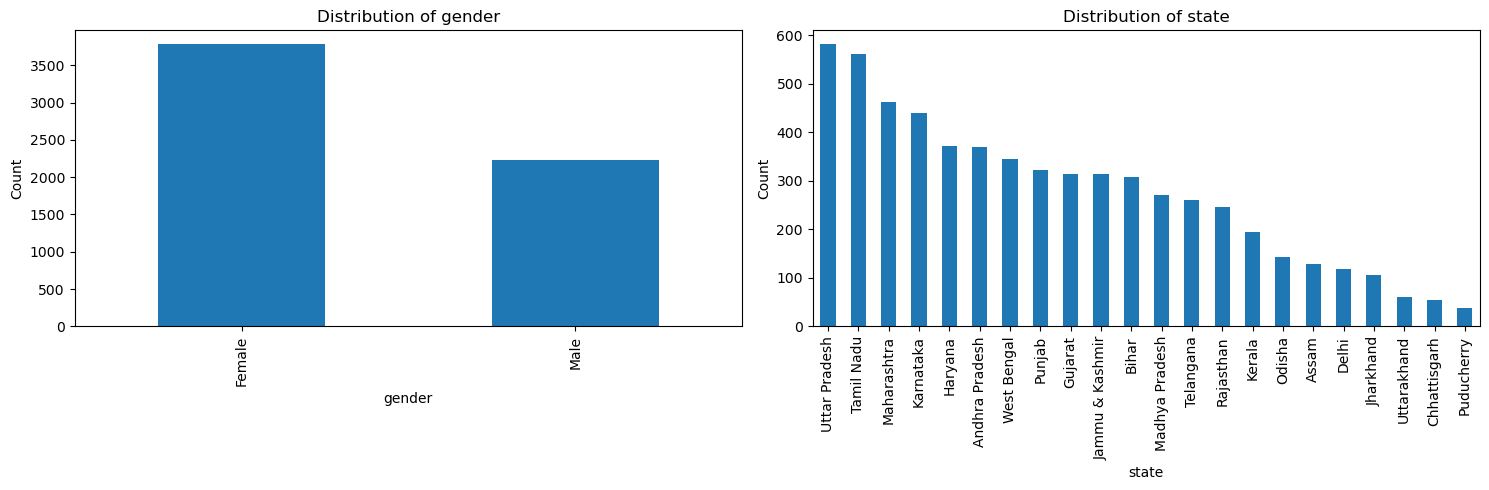

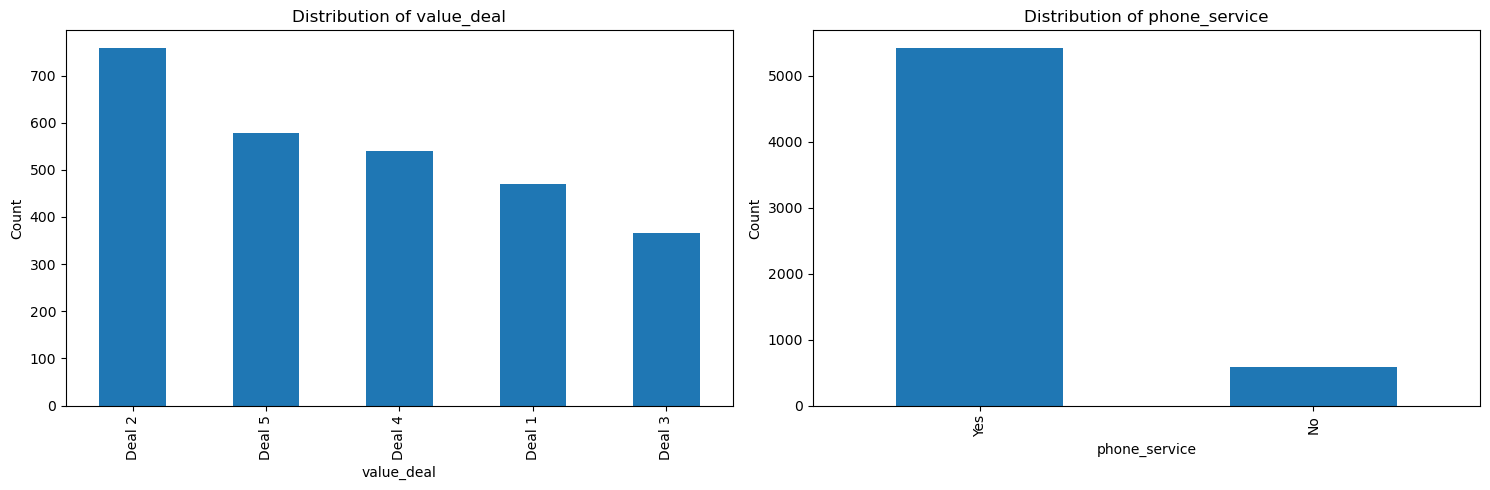

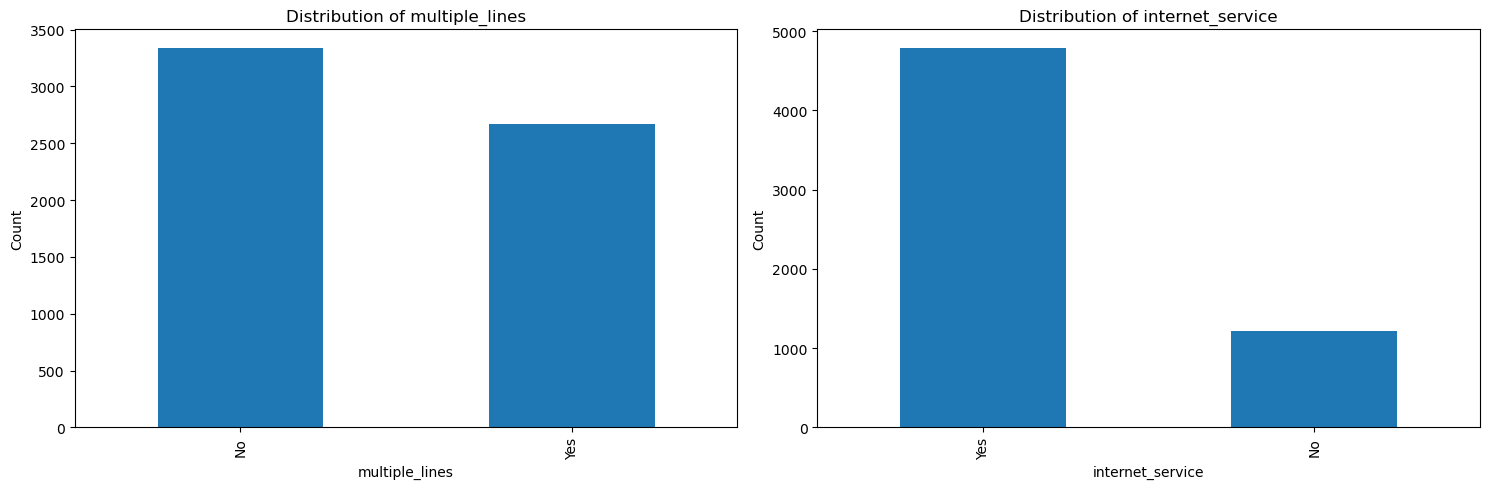

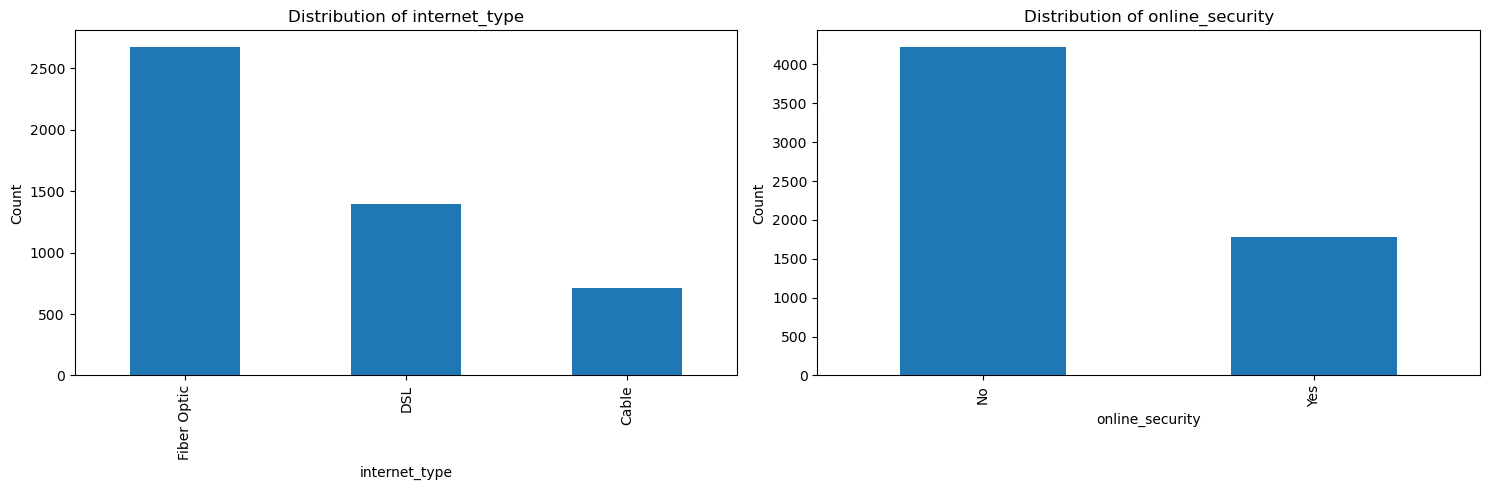

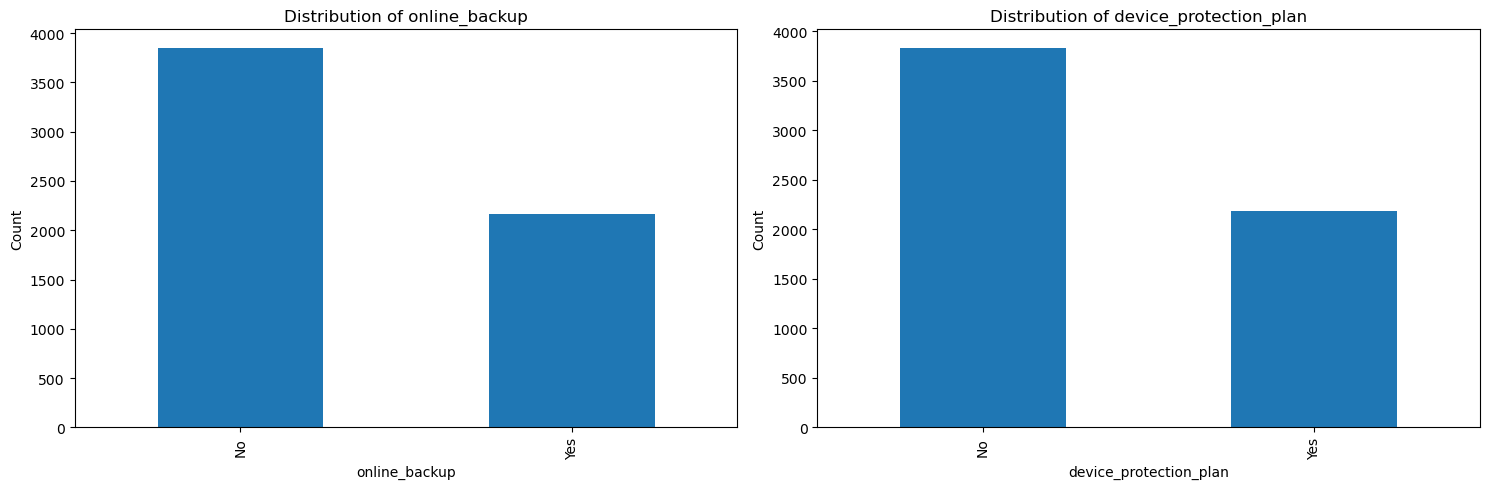

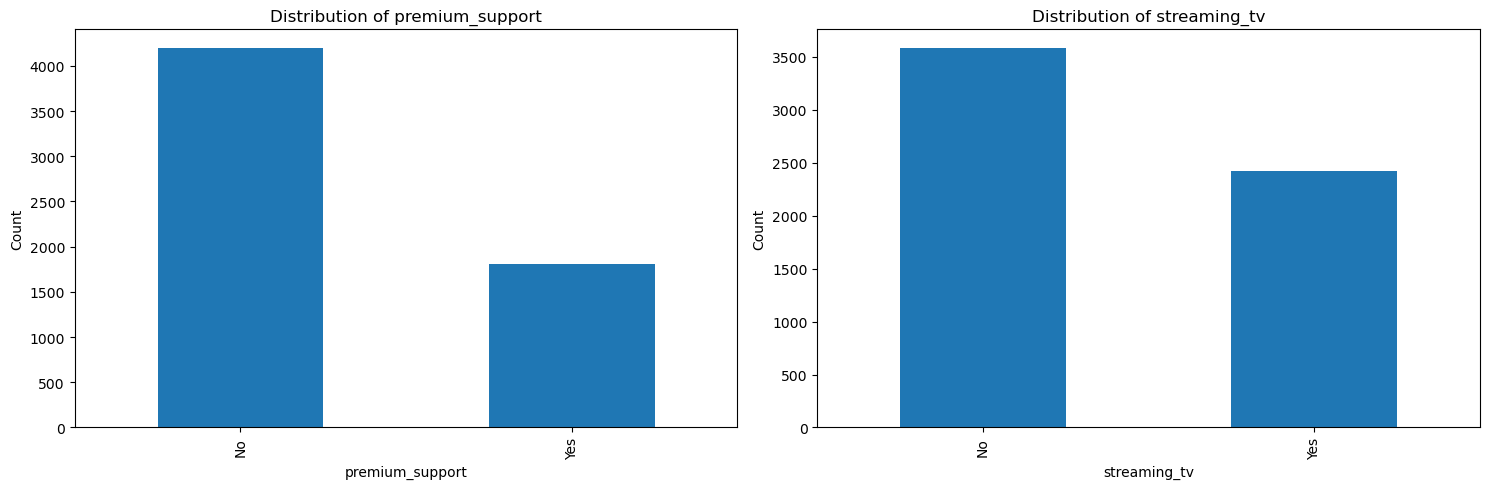

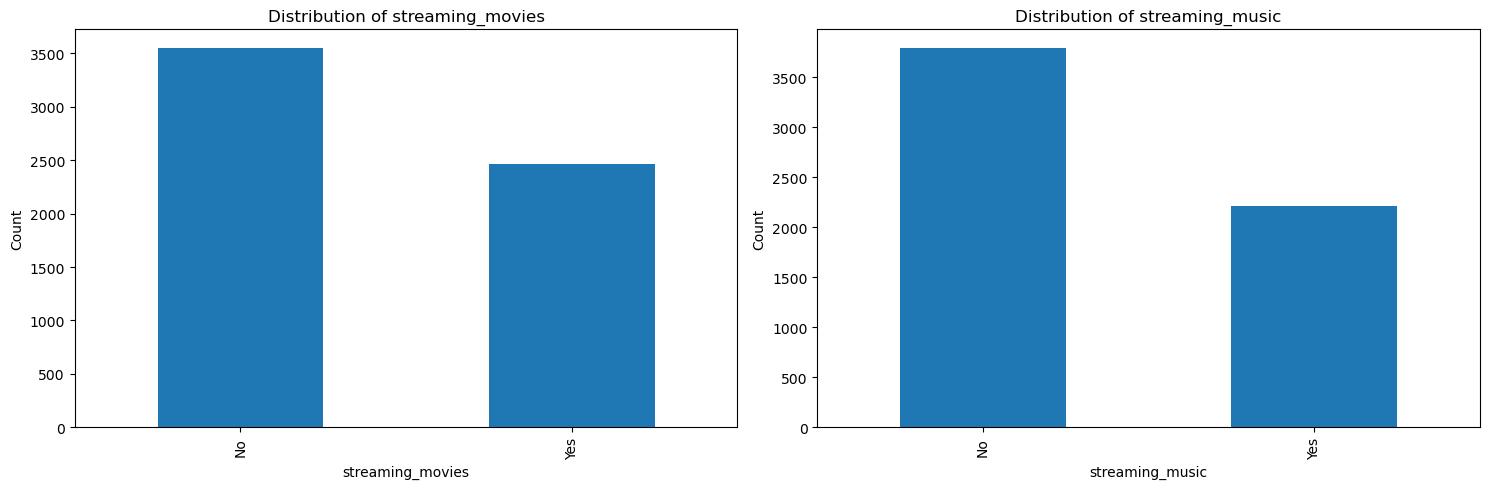

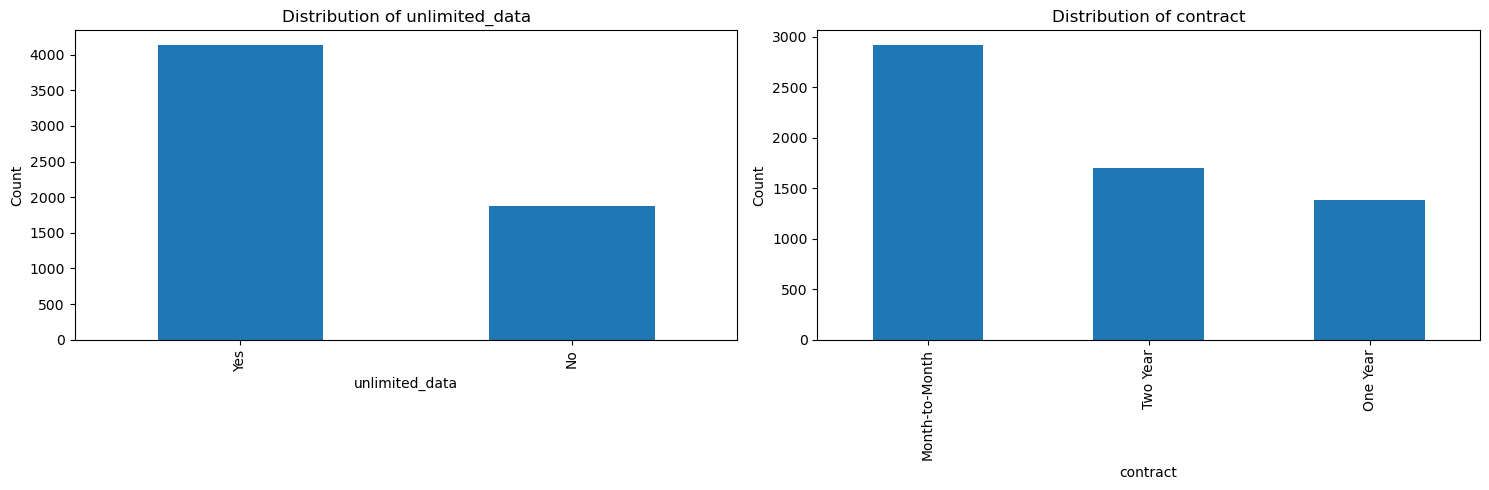

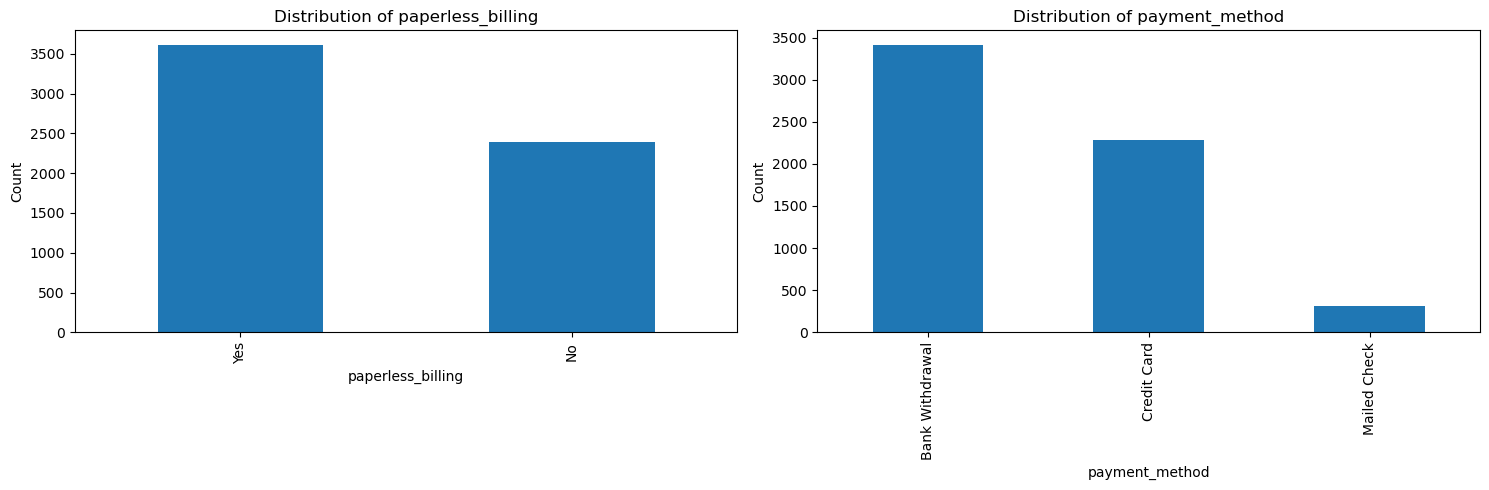

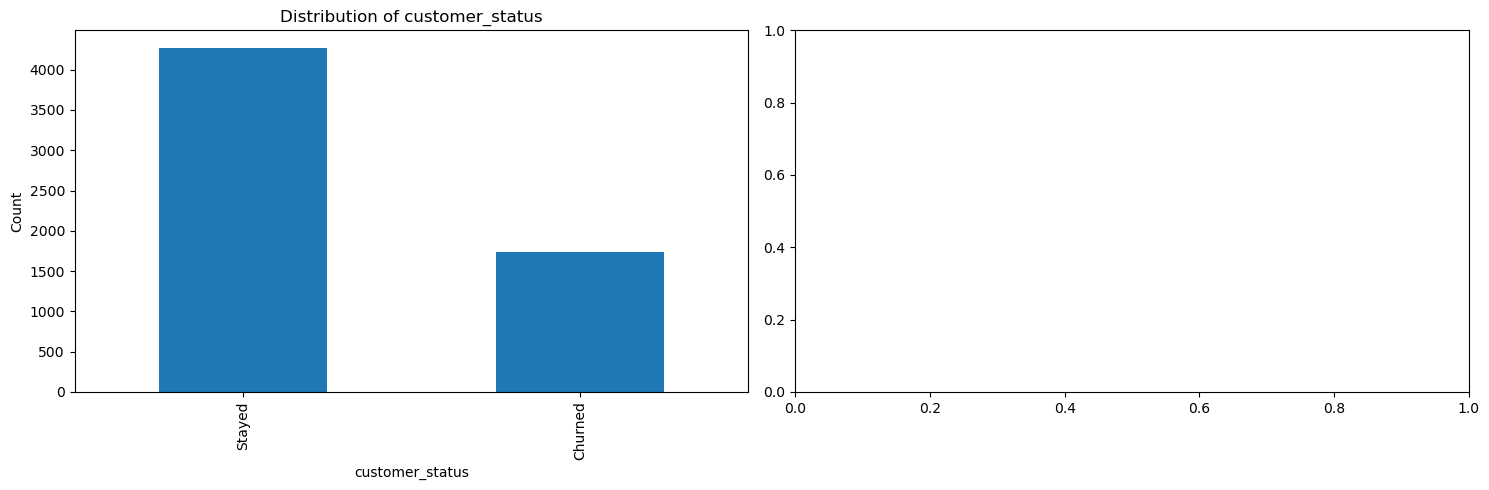

In [49]:
import matplotlib.pyplot as plt
# Plot bar charts for each pair of categorical columns
for i in range(0, len(categorical_columns), 2):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    for j in range(2):
        if i + j < len(categorical_columns):
            column = categorical_columns[i + j]
            churndata[column].value_counts().plot(kind='bar', ax=axes[j])
            axes[j].set_title(f'Distribution of {column}')
            axes[j].set_xlabel(column)
            axes[j].set_ylabel('Count')
    plt.tight_layout()
    plt.show()

In [50]:
# for the missing values in the value_deal column, fill with No_deal happened
churndata['value_deal'] = churndata['value_deal'].fillna('No Deal')

# removing all nan values for internet_type column
churndata = churndata.dropna(subset=['internet_type'])

## Data Preparation for Classification

We will encode categorical variables and split the dataset into features and target variables.

In [51]:
# Define the mapping for the 'state' column
state_mapping = {
    'Andhra Pradesh': 1,
    'Assam': 2,
    'Bihar': 3,
    'Chhattisgarh': 4,
    'Delhi': 5,
    'Gujarat': 6,
    'Haryana': 7,
    'Jammu & Kashmir': 8,
    'Jharkhand': 9,
    'Karnataka': 10,
    'Kerala': 11,
    'Madhya Pradesh': 12,
    'Maharashtra': 13,
    'Odisha': 14,
    'Puducherry': 15,
    'Punjab': 16,
    'Rajasthan': 17,
    'Tamil Nadu': 18,
    'Telangana': 19,
    'Uttar Pradesh': 20,
    'Uttarakhand': 21,
    'West Bengal': 22
}

# Apply the mapping to the 'state' column
churndata['state'] = churndata['state'].map(state_mapping)

In [52]:
# Define the features for label encoding and one hot encoding
label_encode_features = ['gender', 'phone_service', 'multiple_lines', 'internet_service', 'internet_type', 'online_security', 'online_backup', 'device_protection_plan', 'premium_support', 'streaming_tv', 'streaming_movies', 'streaming_music', 'unlimited_data', 'paperless_billing', 'customer_status']
one_hot_encode_features = ['value_deal', 'contract', 'payment_method']

# Create a dictionary of label encoders for each feature
label_encoders = {feature: LabelEncoder() for feature in label_encode_features}

# Apply label encoding to the specified features
for feature in label_encode_features:
    churndata[feature] = label_encoders[feature].fit_transform(churndata[feature])

# Apply one hot encoding to the specified features
churndata = pd.get_dummies(churndata, columns=one_hot_encode_features)

In [53]:
# Define the features to be normalized
normalize_features = ['age', 'number_of_referrals', 'tenure_in_months',  'device_protection_plan', 'premium_support', 'monthly_charge', 'total_charges', 'total_refunds', 'total_long_distance_charges', 'total_revenue']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply the scaler to the specified features
churndata[normalize_features] = scaler.fit_transform(churndata[normalize_features])

In [54]:
churndata.to_csv('final_data.csv', index=False)

## Classification Models

We will implement some classification models and compare the outputs to find the best model for our dataset.

In [55]:
# read the CSV file
df = pd.read_csv('final_data.csv')

In [56]:
# Assuming the target variable is named 'target'
X = df.drop('customer_status', axis=1)
y = df['customer_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [57]:
# Define the models
models = {
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Neural Network': MLPClassifier()
}

# Define parameter grids for each model
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs']
    },
    'K-Nearest Neighbors': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance']
   
    },
    'Neural Network': {
        'hidden_layer_sizes': [(50,), (50, 50)],
        'activation': ['tanh', 'relu'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.001, 0.01]
    }
}

# Dictionary to store the best models
best_models = {}

# Perform GridSearchCV for each model
for name, model in models.items():
    print(f"Optimizing {name}...")
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")

# Evaluate the best models
results = {'Model': [], 'Train Accuracy': [], 'Test Accuracy': []}

for name, model in best_models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    results['Model'].append(name)
    results['Train Accuracy'].append(train_accuracy)
    results['Test Accuracy'].append(test_accuracy)

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)
print(results_df)

Optimizing Random Forest...
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Optimizing Logistic Regression...


c:\Users\ahmed\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best parameters for Logistic Regression: {'C': 100, 'solver': 'lbfgs'}
Optimizing K-Nearest Neighbors...
Best parameters for K-Nearest Neighbors: {'n_neighbors': 7, 'weights': 'uniform'}
Optimizing Neural Network...


c:\Users\ahmed\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters for Neural Network: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50,), 'solver': 'adam'}


c:\Users\ahmed\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                 Model  Train Accuracy  Test Accuracy
0        Random Forest        0.903289       0.828595
1  Logistic Regression        0.804627       0.798495
2  K-Nearest Neighbors        0.813545       0.746656
3       Neural Network        0.839186       0.797659


c:\Users\ahmed\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


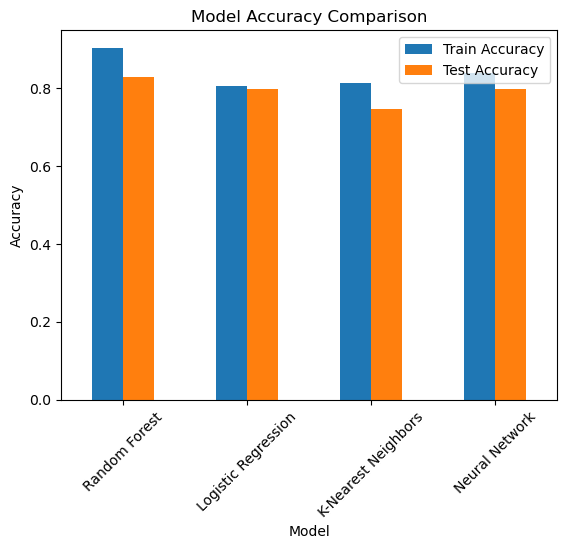

In [58]:
# Plot the results
results_df.plot(x='Model', y=['Train Accuracy', 'Test Accuracy'], kind='bar')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.show()

In [59]:
# Find the model with the best accuracy
best_model_name = results_df.loc[results_df['Test Accuracy'].idxmax(), 'Model']
best_model = models[best_model_name]

# Save the best model to a file
joblib.dump(best_model, 'best_model.pkl')
print(f"Best model ({best_model_name}) saved to 'best_model.pkl'")

Best model (Random Forest) saved to 'best_model.pkl'
